# Gold marker segmentation with QSM

## Imports

In [1]:
import fastai
from glob import glob
import fastai.vision.learner
import fastai.vision.models
import fastai.data.core
import fastai.callback.all
import fastai.losses
import fastcore.dispatch
import fastcore.basics
import numpy as np
import nibabel as nib
import torch
import cv2
from matplotlib import pyplot as plt

## Prepare data
### Locate input data

The files are 3D NIfTI images.

In [2]:
# Input data
qsm_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*qsm.nii*"))
seg_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*segmentation*clean_seeds.nii*"))
t2s_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*t2starmap.nii*"))
mag_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*magnitude_combined.nii*"))
assert(len(qsm_files) == len(seg_files) == len(t2s_files) == len(mag_files))
print(f"{len(qsm_files)} NIfTI image sets found in data/bids (QSM, segmentations, T2*, magnitude).")

10 NIfTI image sets found in data/bids (QSM, segmentations, T2*, magnitude).


### Identify the slices where segmentations exist

In [3]:
# array of slice indices where segmentations exist
def get_seg_indices(seg_path):
    seg = nib.load(seg_path).get_fdata()
    seg_indices = np.unique(np.where(seg > 0)[2])
    return seg_indices
 
# samples[sample_num] == [image_num, slice_num]
def get_samples(qsm_files, seg_files):
    samples = []
    sample_count = 0
    for image_num in range(len(qsm_files)):
        seg_indices = get_seg_indices(seg_files[image_num])
        for seg_index in seg_indices:
            samples.append([qsm_files[image_num], seg_files[image_num], seg_index])
    return samples

In [4]:
samples = np.array(get_samples(qsm_files, seg_files))
samples = np.random.permutation(samples)
cut = int(0.8 * len(samples))
train_samples, valid_samples = samples[:cut], samples[cut:]
print(f"{len(train_samples)} training samples and {len(valid_samples)} validation samples selected.")

54 training samples and 14 validation samples selected.


In [5]:
print("Training sample #1:", train_samples[0])
print("Validation sample #1:", valid_samples[0])

Training sample #1: ['data/bids/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_run-01_qsm.nii'
 'data/bids/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_run-01_segmentation_clean_seeds.nii'
 '29']
Validation sample #1: ['data/bids/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_run-01_qsm.nii'
 'data/bids/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_run-01_segmentation_clean_seeds.nii'
 '29']


### Load samples as a PyTorch dataset and fastai 'dataloaders'

In [6]:
class QSM_2D_With_Seg(torch.utils.data.Dataset):
    def __init__(self, sample_details, transform=None):
        self.sample_details = sample_details
        self.transform = transform

    def __len__(self):
        return len(self.sample_details) * 3

    def __getitem__(self, idx):
        # convert idx to list if tensor
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # convert idx to image and slice numbers
        qsm_path, seg_path, slice_id = self.sample_details[idx % len(self.sample_details)]

        # load data and scale from estimated range of -8,+8 to 0,1
        qsm = (nib.load(qsm_path).get_fdata()[:,:,int(slice_id)])
        seg = (nib.load(seg_path).get_fdata()[:,:,int(slice_id)])

        # resize images to common size
        qsm = torch.Tensor(cv2.resize(qsm, dsize=(224, 224)))
        seg = torch.Tensor(cv2.resize(seg, dsize=(224, 224), interpolation=cv2.INTER_NEAREST))

        # expand QSM over 3 channels for RGB models
        qsm = qsm.expand(3, 224, 224)
        
        # apply any necessary transformations
        if self.transform:
            pass

        # ensure segmentation is long int
        seg = seg.to(torch.int64)

        # rotate image
        num_rotations = idx // len(self.sample_details)
        seg = torch.rot90(seg, num_rotations, [0, 1])
        qsm = torch.rot90(qsm, num_rotations, [1, 2])

        # scale qsm
        qsm = np.interp(np.clip(qsm, -2, 0.5), (-2, 0.5), (0, 1))

        return fastai.torch_core.TensorImage(qsm), fastai.torch_core.TensorMask(seg)

    def __iter__(self):
        for idx in range(len(self.sample_details)):
            yield self.__getitem__(idx)

In [7]:
train_ds = QSM_2D_With_Seg(train_samples)
valid_ds = QSM_2D_With_Seg(valid_samples)
dls = fastai.data.core.DataLoaders.from_dsets(train_ds, valid_ds, batch_size=8, device='cuda:0')
print(f"Training set contains {len(train_ds)} samples.")
print(f"Validation set contains {len(valid_ds)} samples.")

Training set contains 162 samples.
Validation set contains 42 samples.


=== INPUT ===


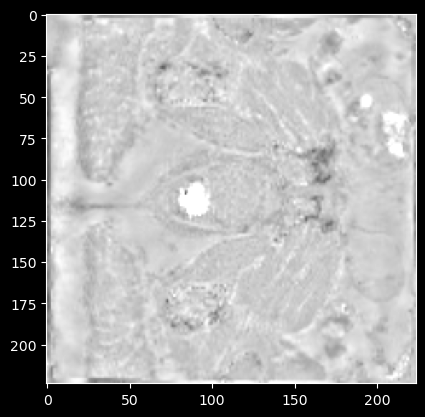

=== LABEL ===


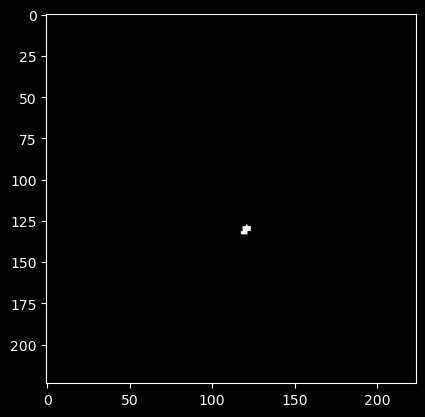

In [8]:
batch = dls.train.one_batch()
sample_num = 5
x = batch[0][sample_num].unsqueeze(0) # image
y = batch[1][sample_num] # mask

print("=== INPUT ===")
plt.figure()
plt.imshow(x[0][0].cpu(), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()

print("=== LABEL ===")
plt.figure()
plt.imshow(y.cpu(), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()

## Prepare learner

In [9]:
learn = fastai.vision.learner.unet_learner(
    dls=dls,                            # data loader
    arch=fastai.vision.models.resnet34, # model architecture
    n_out=2,
    loss_func=fastai.losses.CrossEntropyLossFlat(axis=1), # loss function for evaluation during training
    model_dir='models',                  # save directory for trained model
)

In [10]:
#learn.summary()

In [11]:
#learn.lr_find()

=== INPUT ===


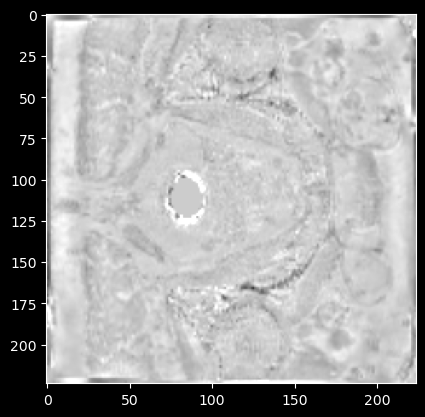

=== LABEL ===


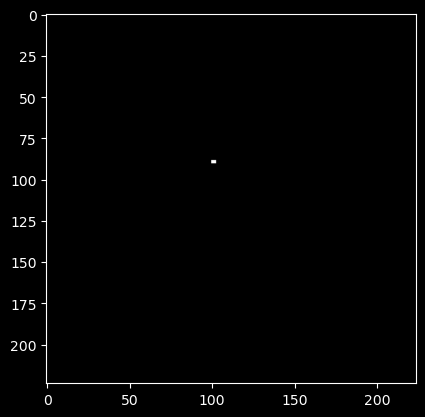

In [12]:
sample_num = 5
x, y = dls.train_ds[sample_num]

print("=== INPUT ===")
plt.figure()
plt.imshow(x[0].cpu(), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()

print("=== LABEL ===")
plt.figure()
plt.imshow(y.cpu(), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()

=== INPUT ===


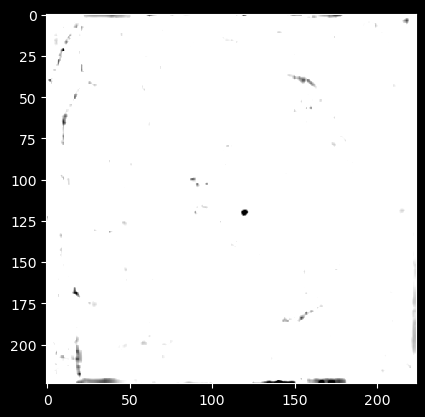

=== PREDICTION ===


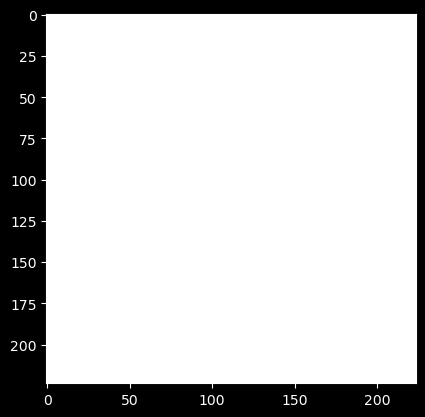

=== GROUND TRUTH ===


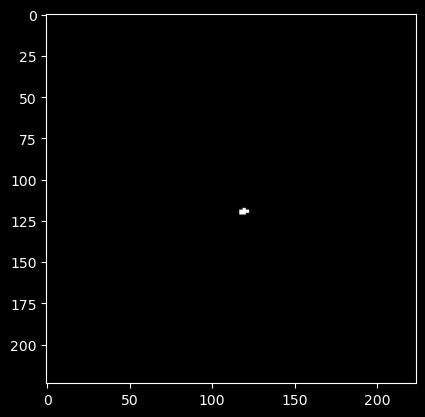

In [13]:
batch = dls.train.one_batch()
x = batch[0][0].unsqueeze(0) # image
y = batch[1][0] # mask

print("=== INPUT ===")
plt.figure()
plt.imshow(x[0][1].cpu(), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()

_, _, prediction = learn.predict(x)
prediction = torch.round(prediction)

print("=== PREDICTION ===")
plt.figure()
plt.imshow(prediction[1], cmap='gray', vmin=0, vmax=0.5)
plt.show()
plt.close()

print("=== GROUND TRUTH ===")
plt.figure()
plt.imshow(y.cpu(), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()

## Train

In [14]:
learn.fine_tune(4, base_lr=0.001)

epoch,train_loss,valid_loss,time
0,0.128179,0.008132,00:07


epoch,train_loss,valid_loss,time
0,0.002788,0.002152,00:04
1,0.001923,0.001867,00:04
2,0.001333,0.001969,00:04
3,0.001031,0.002366,00:04


# Test

=== INPUT ===


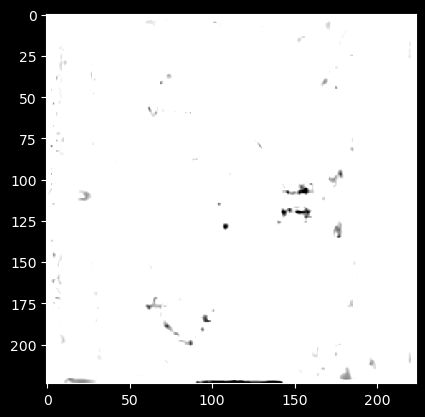

=== PREDICTION ===


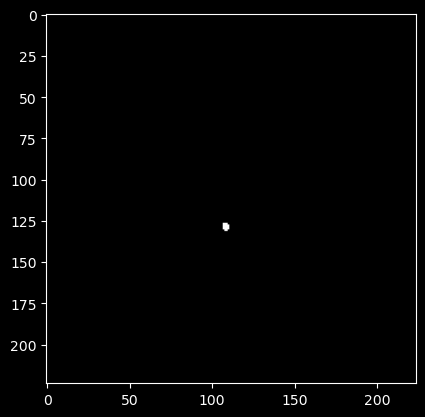

=== GROUND TRUTH ===


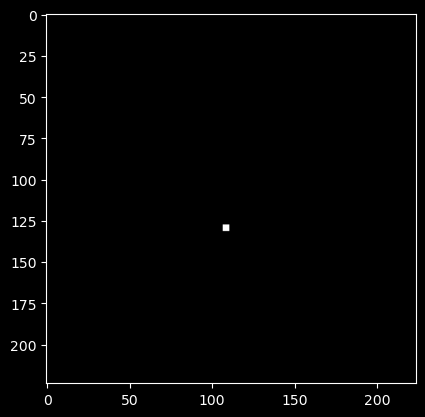

In [15]:
batch = dls.train.one_batch()
x = batch[0][0].unsqueeze(0) # image
y = batch[1][0] # mask

print("=== INPUT ===")
plt.figure()
plt.imshow(x[0][1].cpu(), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()

_, _, prediction = learn.predict(x)
prediction = torch.round(prediction)

print("=== PREDICTION ===")
plt.figure()
plt.imshow(prediction[1], cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()

print("=== GROUND TRUTH ===")
plt.figure()
plt.imshow(y.cpu(), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()

=== INPUT ===


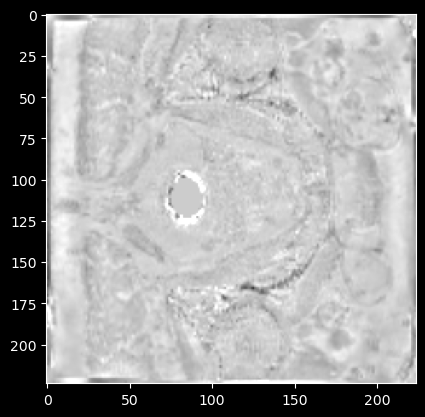

=== PREDICTION ===


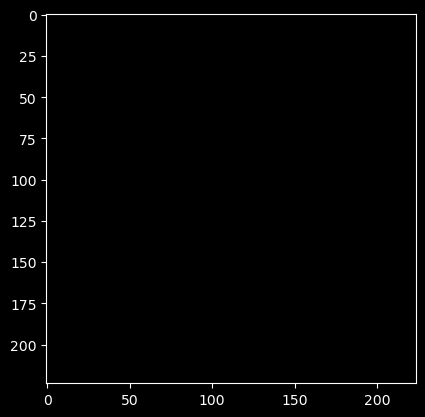

=== GROUND TRUTH ===


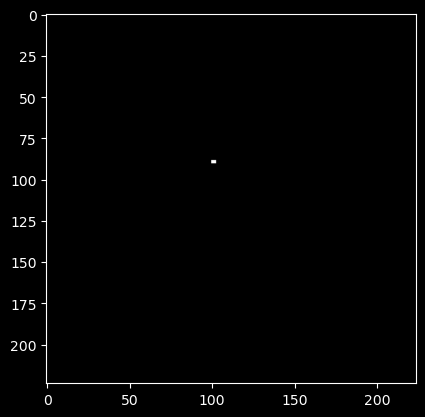

In [18]:
sample_num = 5
x, y = dls.train_ds[sample_num]

print("=== INPUT ===")
plt.figure()
plt.imshow(x[0].cpu(), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()

_, _, prediction = learn.predict(x.unsqueeze(0))
prediction = torch.round(prediction)

print("=== PREDICTION ===")
plt.figure()
plt.imshow(prediction[1], cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()

print("=== GROUND TRUTH ===")
plt.figure()
plt.imshow(y.cpu(), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()